In [1]:
# 1. Import Library Utama
import pandas as pd
import numpy as np
import os
import re
import string

# Preprocessing teks
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import torch
from torch.utils.data import Dataset, DataLoader

# Deep Learning
import torch.nn as nn
import torch.optim as optim

# HuggingFace Transformers
os.environ["USE_TF"] = "0" 
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Evaluasi
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Save Model
import joblib
import pickle


c:\Users\dimas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# 2. Load Dataset
# Path base folder
BASE_DIR = "../data/raw/dataset_presidential/cleaned_data/"

# 2. Baca semua dataset
df_ab = pd.read_csv(os.path.join(BASE_DIR, "AB.csv"))
df_gp = pd.read_csv(os.path.join(BASE_DIR, "GP.csv"))
df_ps = pd.read_csv(os.path.join(BASE_DIR, "PS.csv"))

# 3. Tambahkan kolom source (opsional, biar tau asal data)
df_ab["source"] = "AB"
df_gp["source"] = "GP"
df_ps["source"] = "PS"

# 4. Gabungkan
df_all = pd.concat([df_ab, df_gp, df_ps], ignore_index=True)

# 5. Cek hasil
print("Total data:", df_all.shape)
print(df_all.head())

# 6. Simpan ke processed (buat folder kalau belum ada)
os.makedirs("../data/processed", exist_ok=True)
df_all.to_csv("../data/processed/sentiment_dataset.csv", index=False)


Total data: (23449, 16)
   Unnamed: 0.1                        Date                     Created  \
0           0.0   2023-04-16 10:04:35+00:00   2023-03-27 08:59:57+00:00   
1           1.0   2023-04-16 10:00:01+00:00   2012-08-21 07:34:04+00:00   
2           2.0   2023-04-16 09:14:46+00:00   2011-09-27 05:22:24+00:00   
3           3.0   2023-04-16 07:03:05+00:00   2017-10-19 12:32:28+00:00   
4           4.0   2023-04-16 06:03:59+00:00   2022-06-28 07:03:37+00:00   

        User ID   Followers   Following   Tweet Count       TweetLocation  \
0  1.640000e+18         981         531            22                 NaN   
1  7.710306e+08       10702         123         30121   Palmerah, Jakarta   
2  3.807551e+08          11          35           230       North Jakarta   
3  9.210000e+17          37          47          2670             Jakarta   
4  1.540000e+18           6         129           766       Lebak, Banten   

                                                Text  \
0     

In [3]:
# Hapus kolom yang tidak dipakai
df_all = df_all.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore")

# Ambil hanya kolom utama
df_clean = df_all[["Text", "label", "source"]]
print(df_clean.head())

                                                Text     label source
0                               anies president info  Positive     AB
1  gerindra party politician sandiaga uno answers...  Positive     AB
2  mr. anies continued, we will guard him until h...  Positive     AB
3  may allah swt save the nation and state of the...  Positive     AB
4  poor chotimah, uncle anies, that's why my fami...  Positive     AB


In [4]:
print(df_clean["label"].value_counts())

label
Positive    17033
Negative     6413
Name: count, dtype: int64


In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # hapus URL
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # hapus angka & simbol
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_clean["clean_text"] = df_clean["Text"].astype(str).apply(clean_text)
print(df_clean[["Text", "clean_text", "label"]].head())

                                                Text  \
0                               anies president info   
1  gerindra party politician sandiaga uno answers...   
2  mr. anies continued, we will guard him until h...   
3  may allah swt save the nation and state of the...   
4  poor chotimah, uncle anies, that's why my fami...   

                                          clean_text     label  
0                               anies president info  Positive  
1  gerindra party politician sandiaga uno answers...  Positive  
2  mr anies continued we will guard him until he ...  Positive  
3  may allah swt save the nation and state of the...  Positive  
4  poor chotimah uncle anies thats why my family ...  Positive  


C:\Users\dimas\AppData\Local\Temp\ipykernel_18240\3057459240.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["clean_text"] = df_clean["Text"].astype(str).apply(clean_text)


In [6]:
# 1. Cek jumlah missing
print("Missing clean_text:", df_clean["clean_text"].isna().sum())
print("Missing label:", df_clean["label"].isna().sum())

# 2. Tampilkan baris yang kena drop (NaN di clean_text atau label)
rows_to_drop = df_clean[df_clean[["clean_text", "label"]].isna().any(axis=1)]
print("\nRows yang dibuang karena NaN:")
print(rows_to_drop)

# 3. Drop data yang label atau teks kosong
df_clean = df_clean.dropna(subset=["clean_text", "label"])

# 4. Split train-test
X = df_clean["clean_text"]
y = df_clean["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain size:", X_train.shape, "Test size:", X_test.shape)

Missing clean_text: 0
Missing label: 3

Rows yang dibuang karena NaN:
                                                 Text label source  \
58               presidential candidate goodbye anies   NaN     AB   
60  but why are you competing to become president ...   NaN     AB   
63  very different from the governor of jakarta, w...   NaN     AB   

                                           clean_text  
58               presidential candidate goodbye anies  
60  but why are you competing to become president ...  
63  very different from the governor of jakarta wh...  

Train size: (18756,) Test size: (4690,)


In [7]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

===== Logistic Regression =====
              precision    recall  f1-score   support

    Negative       0.66      0.87      0.75      1283
    Positive       0.94      0.83      0.88      3407

    accuracy                           0.84      4690
   macro avg       0.80      0.85      0.81      4690
weighted avg       0.86      0.84      0.84      4690



===== Naive Bayes =====
              precision    recall  f1-score   support

    Negative       0.70      0.29      0.41      1283
    Positive       0.78      0.95      0.86      3407

    accuracy                           0.77      4690
   macro avg       0.74      0.62      0.63      4690
weighted avg       0.76      0.77      0.74      4690



===== SVM (LinearSVC) =====
              precision    recall  f1-score   support

    Negative       0.68      0.84      0.75      1283
    Positive       0.93      0.85      0.89      3407

    accuracy                           0.85      4690
   macro avg       0.81      0.85      0

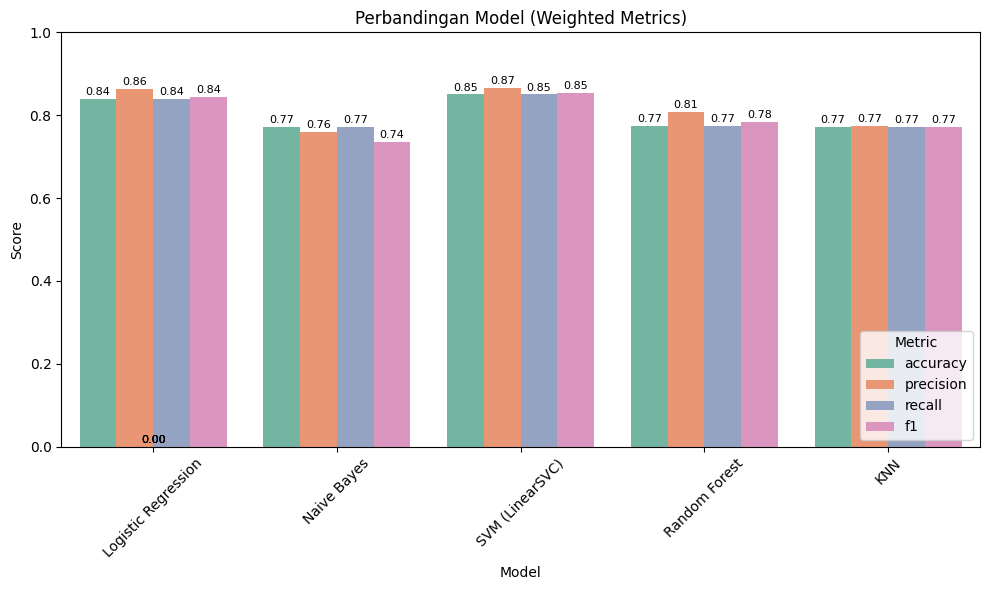

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, class_weight="balanced"),
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC(class_weight="balanced", max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        class_weight="balanced",
        random_state=42,
        max_depth=20
    ),
    "KNN": KNeighborsClassifier(n_neighbors=10, metric="cosine")
}

# Simpan hasil metric ke dict
results = {}
trained_models = {}

for name, clf in models.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, output_dict=True)

    results[name] = {
        "accuracy": report["accuracy"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }

    trained_models[name] = clf  # simpan instance model yg sudah dilatih

    print(f"===== {name} =====")
    print(classification_report(y_test, y_pred))
    print("\n")

df_results = pd.DataFrame(results).T  # Transpose biar model jadi index

# # Pilih model terbaik (berdasarkan f1 misalnya)
# best_model_name = df_results["f1"].idxmax()
# best_model = trained_models[best_model_name]
# print(f"Model terbaik: {best_model_name} (F1: {df_results['f1'].max():.4f})")

# # Simpan model terbaik ke folder models/
# os.makedirs("models", exist_ok=True)
# model_path = os.path.join("models", f"{best_model_name.replace(' ', '_').lower()}.pkl")

# with open(model_path, "wb") as f:
#     pickle.dump(best_model, f)

# print(f"Model disimpan di: {model_path}")

# # Simpan vectorizer agar bisa dipakai saat inference 
# vectorizer_path = os.path.join("models", "tfidf_vectorizer.pkl")
# with open(vectorizer_path, "wb") as f:
#     pickle.dump(vectorizer, f)

# print(f"Vectorizer disimpan di: {vectorizer_path}")

# Convert ke long format biar seaborn otomatis bikin legend per metric
df_long = df_results.reset_index().melt(id_vars="index", var_name="Metric", value_name="Score")
df_long.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=df_long, x="Model", y="Score", hue="Metric", palette="Set2")

# Tambah skor di atas bar
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        fontsize=8, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

plt.title("Perbandingan Model (Weighted Metrics)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

## Deep Learning / Bert

In [11]:
# Path base folder
BASE_DIR = "../data/raw/dataset_presidential/labeled_data/"

# 2. Baca semua dataset
df_ab_labeled = pd.read_csv(os.path.join(BASE_DIR, "AB.csv"))
df_gp_labeled = pd.read_csv(os.path.join(BASE_DIR, "GP.csv"))
df_ps_labeled = pd.read_csv(os.path.join(BASE_DIR, "PS.csv"))

# 3. Tambahkan kolom source (opsional, biar tau asal data)
df_ab_labeled["source"] = "AB"
df_gp_labeled["source"] = "GP"
df_ps_labeled["source"] = "PS"

# 4. Gabungkan
df_all_labeled = pd.concat([df_ab, df_gp, df_ps], ignore_index=True)

# 5. Cek hasil
print("Total data:", df_all_labeled.shape)
print(df_all_labeled.head())

# 6. Simpan ke processed (buat folder kalau belum ada)
os.makedirs("../data/processed", exist_ok=True)
df_all_labeled.to_csv("../data/processed/sentiment_dataset_labeled.csv", index=False)


Total data: (23449, 16)
   Unnamed: 0.1                        Date                     Created  \
0           0.0   2023-04-16 10:04:35+00:00   2023-03-27 08:59:57+00:00   
1           1.0   2023-04-16 10:00:01+00:00   2012-08-21 07:34:04+00:00   
2           2.0   2023-04-16 09:14:46+00:00   2011-09-27 05:22:24+00:00   
3           3.0   2023-04-16 07:03:05+00:00   2017-10-19 12:32:28+00:00   
4           4.0   2023-04-16 06:03:59+00:00   2022-06-28 07:03:37+00:00   

        User ID   Followers   Following   Tweet Count       TweetLocation  \
0  1.640000e+18         981         531            22                 NaN   
1  7.710306e+08       10702         123         30121   Palmerah, Jakarta   
2  3.807551e+08          11          35           230       North Jakarta   
3  9.210000e+17          37          47          2670             Jakarta   
4  1.540000e+18           6         129           766       Lebak, Banten   

                                                Text  \
0     

In [ ]:
# Load dataset processed
df_labeled = pd.read_csv("../data/processed/sentiment_dataset_labeled.csv")

# Ambil hanya kolom yang dibutuhkan
df_labeled = df_labeled[["Text", "label"]]

print(df_labeled.head())
print(df_labeled["label"].value_counts())

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # hapus url
    text = re.sub(r"@\w+|#\w+", "", text)                # hapus mention/hashtag
    text = re.sub(r"[^\w\s]", "", text)                  # hapus tanda baca
    text = re.sub(r"\d+", "", text)                      # hapus angka
    text = re.sub(r"\s+", " ", text).strip()             # hapus spasi ganda
    return text

df_labeled["clean_text"] = df_labeled["Text"].astype(str).apply(clean_text)

In [ ]:
le = LabelEncoder()
df_labeled["label_encoded"] = le.fit_transform(df_labeled["label"])
print(dict(zip(le.classes_, le.transform(le.classes_))))


In [ ]:
from sklearn.model_selection import train_test_split

X_train_labeled, X_test_labeled, y_train_labeled, y_test_labeled = train_test_split(
    df_labeled["clean_text"], 
    df_labeled["label_encoded"], 
    test_size=0.2, 
    random_state=42, 
    stratify=df_labeled["label_encoded"]
)

In [ ]:
# Tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def encode_batch(texts, labels):
    encodings = tokenizer(
        list(texts), 
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors="pt"
    )
    return encodings, torch.tensor(labels.values)  # kalo labels masih Series

# Encode train & test
train_encodings, y_train_t = encode_batch(X_train_labeled, y_train_labeled)
test_encodings, y_test_t = encode_batch(X_test_labeled, y_test_labeled)

# Dataset wrapper
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train_t)
test_dataset = SentimentDataset(test_encodings, y_test_t)

# Model IndoBERT
model_labeled = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", 
    num_labels=2
)

In [ ]:
# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",          # folder hasil training (log + checkpoints)
    evaluation_strategy="epoch",     # evaluasi tiap epoch
    save_strategy="epoch",           # simpan tiap epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,              # hanya simpan 2 checkpoint terbaik
)

# Trainer
trainer = Trainer(
    model=model_labeled,             # ⚡ pakai model_labeled (bukan model)
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Save final model & tokenizer ke folder models/
save_dir = "./models/indoBERT-sentiment"
model_labeled.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)